Encoder:
real data = $28*28$ -> fc, tanh -> 1024 -> fc, tanh -> 1024 -> fc, tanh -> 10

Decoder:
encoded data = 10 -> fc, tanh -> 1024 -> fc, tanh -> 1024 -> fc, sigmoid -> $28*28$

Generator:
prior samples = 10 -> fc, tanh -> 1024 -> fc, tanh -> 1024 -> fc, sigmoid -> $28*28$

Discriminator:


In [1]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

W0316 20:13:52.177997 20352 deprecation.py:323] From <ipython-input-1-414bc36c1216>:3: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0316 20:13:52.180943 20352 deprecation.py:323] From C:\Users\111\.conda\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0316 20:13:52.181941 20352 deprecation.py:323] From C:\Users\111\.conda\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0316 20:13:52.412586 20352 deprecation.py:323] From C:\Users\111\.conda\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0316 20:13:52.417566 20352 deprecation.py:323] From C:\Users\111\.conda\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0316 20:13:52.480968 20352 deprecation.py:323] From C:\Users\111\.conda\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def he_initializer(size):
    """
    for ReLU - layers initialization
    """
    return tf.random_normal_initializer(mean = 0.0, stddev = np.sqrt(1.0/size), seed = None, dtype = tf.float32)

In [3]:
def linear_layer(tensor, input_size, output_size, init_fn = he_initializer):
    W = tf.get_variable('W', shape = [input_size, output_size], initializer = init_fn(input_size))
    b = tf.get_variable('b', shape = [output_size], initializer = tf.constant_initializer(0.1))
    return tf.add(tf.matmul(tensor, W), b)

Text(0.5, 1.0, 'empirical distribution of generator inputs')

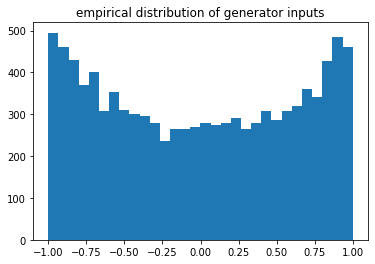

In [4]:
def sample_prior(loc = 0., scale = 1., size = (64,10)):
    """
    generates random mini-batches from given generator distribution
    """
    return np.tanh(np.random.normal(loc = loc, scale = scale, size = size))

X = sample_prior(size = (1000,10))
X = X.flatten()
plt.hist(X, bins = 30)
plt.title('empirical distribution of generator inputs')

In [5]:
class AAE(object):
    """
    Adversarial Autoencoder model
    """
    def __init__(self, batch_size = 64, input_space = 28*28, latent_space = 10, p = 3.,
                ae_middle_layers = [1024, 1024], disc_middle_layers = [64, 64, 1], activation_fn = tf.nn.tanh, learning_rate = 0.001,
                l2_lambda = 0.001, initializer_fn = he_initializer):
        
        self.batch_size = batch_size
        self.input_space = input_space #size of single input data
        self.latent_space = latent_space #size of encoded representation of input data
        self.p = p #threshold for generator loss
        # while generator loss > log(p) train generator, otherwise train discriminator
        self.ae_middle_layers = ae_middle_layers #list of sizes of middle layers in autoencoder
        self.disc_middle_layers = disc_middle_layers #list of sizes of middle layers in discriminator
        self.activation_fn = activation_fn
        self.learning_rate = learning_rate
        self.initializer_fn = initializer_fn
        
        tf.reset_default_graph()
        
        self.input_x = tf.placeholder(dtype = tf.float32, shape = [None, input_space])
        self.z_tensor = tf.placeholder(dtype = tf.float32, shape = [None, latent_space]) #generator input
        
        with tf.variable_scope("encoder"):
            self._encoder()
        self.encoded = self.encoder_layers[-1]
        #true encoded representation. Has to approximate given generator distribution, represented by z_tensor
        
        with tf.variable_scope("decoder"):
            self.decoder_layers = self._decoder(self.encoded)
            self.decoded = self.decoder_layers[-1] #autoencoder true output
            tf.get_variable_scope().reuse_variables()
            self.generator_layers = self._decoder(self.z_tensor)
            self.generated = tf.nn.sigmoid(self.generator_layers[-1], name = "generated")
            #decoder output of generated encoded representation
        
        with tf.variable_scope("discriminator"):
            self.disc_layers_neg = self._discriminator(self.encoded)
            self.disc_neg = self.disc_layers_neg[-1]
            tf.get_variable_scope().reuse_variables()
            self.disc_layers_pos = self._discriminator(self.z_tensor)
            self.disc_pos = self.disc_layers_pos[-1]
        
        self.pos_loss = tf.nn.relu(self.disc_pos) - self.disc_pos + tf.log(1.0 + tf.exp(-tf.abs(self.disc_pos)))
        self.neg_loss = tf.nn.relu(self.disc_neg) + tf.log(1.0 + tf.exp(-tf.abs(self.disc_neg)))
        self.disc_loss = tf.reduce_mean(tf.add(self.pos_loss, self.neg_loss))
        #how good discriminator distinguish given generator distribution from its approximation by encoded data
        self.enc_loss = tf.reduce_mean(tf.subtract(self.neg_loss, self.disc_neg))
        #how good encoded data approximates given generator distribution (according to discriminator's predictions)
        batch_logloss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits \
                                      (logits = self.decoded, labels = self.input_x), axis = 1)
        self.ae_loss = tf.reduce_mean(batch_logloss)
        # how good autoencoder reconstructs x_input
        disc_ws = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'discriminator')
        ae_ws = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'encoder') + \
                tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'decoder')
        self.l2_loss = tf.multiply(tf.reduce_sum([tf.nn.l2_loss(ws) for ws in ae_ws]), l2_lambda)
        #l2 regularizer for autoencoder weights
        self.gen_loss = tf.add(tf.add(self.enc_loss, self.ae_loss), self.l2_loss)
        #total generator loss
        
        with tf.variable_scope('optimizers'):
            self.train_discriminator = tf.train.RMSPropOptimizer(self.learning_rate)\
                                        .minimize(self.disc_loss, var_list = disc_ws)
            self.train_generator = tf.train.RMSPropOptimizer(self.learning_rate)\
                                        .minimize(self.gen_loss, var_list = ae_ws)
        
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        
    def _encoder(self):
        sizes = [self.input_space] + self.ae_middle_layers + [self.latent_space]
        self.encoder_layers = [self.input_x]
        for i in range(len(sizes) - 1):
            with tf.variable_scope('layer-%s' % i):
                linear = linear_layer(tensor = self.encoder_layers[-1], input_size = sizes[i], \
                                        output_size = sizes[i+1])
                self.encoder_layers.append(self.activation_fn(linear))
        
    def _decoder(self, tensor):
        sizes = [self.latent_space] + self.ae_middle_layers[::-1]
        decoder_layers = [tensor]
        for i in range(len(sizes) - 1):
            with tf.variable_scope('layer-%s' % i):
                linear = linear_layer(tensor = decoder_layers[-1], input_size = sizes[i], \
                                        output_size = sizes[i+1])
                decoder_layers.append(self.activation_fn(linear))
        with tf.variable_scope('output-layer'):
            linear = linear_layer(tensor = decoder_layers[-1], input_size = sizes[-1], \
                                    output_size = self.input_space)
            decoder_layers.append(linear)
        return decoder_layers
        
    def _discriminator(self, tensor):
        sizes = [self.latent_space] + self.disc_middle_layers + [1]
        disc_layers = [tensor]
        for i in range(len(sizes) - 1):
            with tf.variable_scope('layer-%s' % i):
                linear = linear_layer(tensor = disc_layers[-1], input_size = sizes[i], \
                                        output_size = sizes[i+1])
                disc_layers.append(self.activation_fn(linear))
        with tf.variable_scope('class-layer'):
            linear = linear_layer(tensor = disc_layers[-1], input_size = sizes[-1], \
                                    output_size = self.input_space)
            disc_layers.append(linear)
        return disc_layers
        
    def train(self, updates = 10000):
        sess = self.sess
        test_x = mnist.test.images
        gloss = 0. #generator loss (only its part, standed for how good encoded data approximates given generator distribution)
        for i in range(updates):
            batch_x, _ = mnist.train.next_batch(self.batch_size)
            #while generator loss > log(p), train generator
            if gloss > np.log(self.p):
                gloss, _ = sess.run([self.enc_loss, self.train_generator], \
                                    feed_dict = {self.input_x: batch_x})
            #otherwise train discriminator
            else:
                batch_z = sample_prior(scale = 1.0, size = (len(batch_x), self.latent_space))
                gloss, _ = sess.run([self.enc_loss, self.train_discriminator], \
                                    feed_dict = {self.input_x: batch_x, self.z_tensor: batch_z})
    
    def generate_images(self, num):
        gtd = self.sess.run(self.generated, feed_dict = {self.z_tensor: sample_prior(size = (num, 10))})
        return gtd.reshape([-1,28,28])

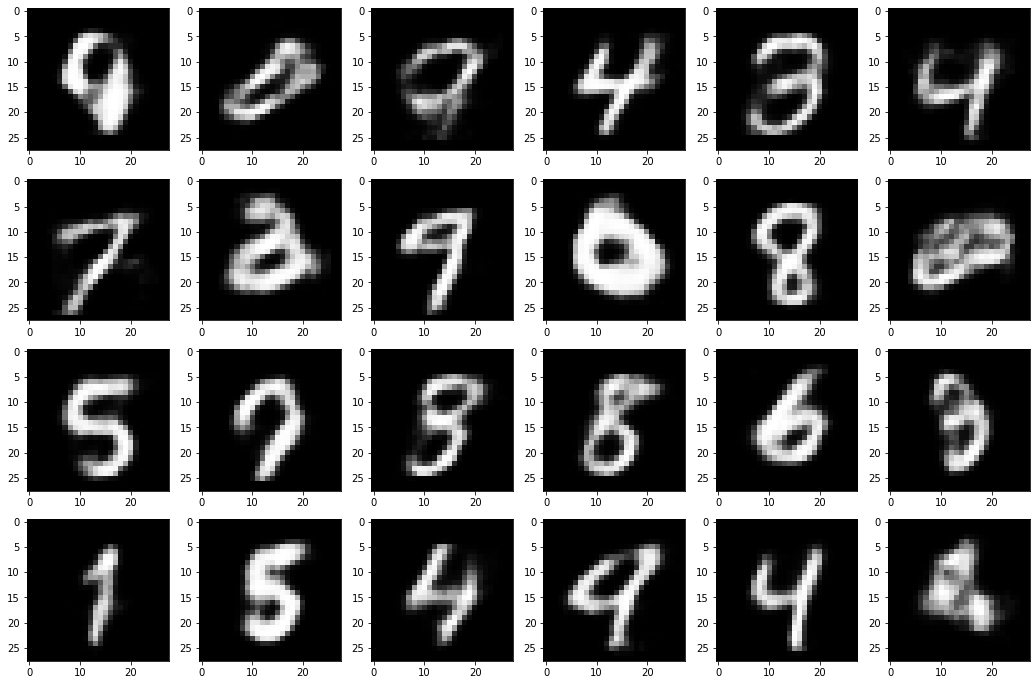

In [8]:
def main():
    aae = AAE()
    aae.train(updates = 20000)
    images = aae.generate_images(num = 24)
    plt.figure(figsize = (18, 12))
    for i in range(4):
        for j in range(6):
            nom = 6*i+j
            plt.subplot(4,6,nom+1)
            plt.imshow(images[nom], cmap = 'gray')

main()